In [1]:
mkdir data/A/ && cp -p data/image_pairs/*A.* data/A/

In [2]:
mkdir data/B/ && cp -p data/image_pairs/*B.* data/B/

In [4]:
ls data/B/

104B.jpg  154B.jpg  203B.jpg  272B.jpg  322B.jpg  403B.jpg  463B.jpg  76B.jpg
111B.jpg  156B.jpg  217B.jpg  299B.jpg  32B.jpg   410B.jpg  466B.png  88B.jpg
116B.jpg  160B.jpg  225B.jpg  305B.jpg  350B.jpg  414B.jpg  488B.jpg  95B.jpg
118B.jpg  171B.jpg  239B.jpg  309B.png  368B.jpg  424B.jpg  49B.jpg   96B.jpg
128B.jpg  178B.jpg  244B.jpg  30B.jpg   373B.jpg  425B.jpg  51B.jpg   9B.jpg
133B.jpg  180B.jpg  261B.jpg  313B.jpg  377B.jpg  446B.jpg  55B.png
143B.jpg  192B.jpg  263B.jpg  317B.jpg  383B.jpg  453B.jpg  72B.jpg
148B.jpg  196B.jpg  267B.jpg  320B.jpg  3B.png    460B.jpg  75B.png


In [5]:
ls data/A/

108A.jpg  195A.jpg  239A.jpg  276A.jpg  311A.jpg  416A.jpg  457A.jpg  73A.jpg
114A.jpg  206A.jpg  242A.jpg  286A.jpg  331A.jpg  419A.jpg  466A.jpg  85A.jpg
132A.jpg  208A.jpg  247A.jpg  295A.jpg  341A.jpg  420A.jpg  479A.jpg  96A.jpg
135A.jpg  211A.jpg  250A.jpg  296A.jpg  356A.jpg  42A.jpg   480A.jpg  99A.jpg
146A.jpg  212A.jpg  259A.jpg  299A.jpg  363A.jpg  433A.jpg  494A.jpg
185A.jpg  218A.jpg  260A.jpg  29A.jpg   370A.jpg  447A.jpg  497A.jpg
190A.jpg  226A.jpg  262A.jpg  2A.jpg    387A.jpg  451A.jpg  505A.jpg
194A.jpg  235A.jpg  267A.jpg  304A.jpg  399A.jpg  456A.jpg  55A.jpg


In [6]:
rm -r data/image_pairs

In [7]:
ls data/

A/  B/


In [8]:
import torchvision
from torchvision import transforms, datasets
import torch
from torch import nn
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader


import faiss
from scipy.spatial.distance import cosine as cos_dist
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [9]:
from os import listdir

#Класс для подготовки данных
class NeighborLoader:
    
    def __init__(self):
        pass
    
    def class2name(self, cl):
        return self._class2name[cl]
    
    def name2class(self, name):
        return self._name2class[name]
    
    def load(self, path):
        names = listdir(path)
        name2class = {}
        class2name = {}
        imgs = []
        labels = []
        for i, name in enumerate(names):
            name2class[name] = i
            class2name[i] = name
            img = NeighborLoader.transform(path+'//'+name) 
            imgs.append(img)
            labels.append(i)
        self._name2class = name2class
        self._class2name = class2name
        return imgs, labels
    
    
    @staticmethod
    def transform(data):
        data_transforms = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]),
    ])
        img = Image.open(data).convert('RGB')   
        return data_transforms(img)#.to('cuda:0')

In [10]:
class BaseModel(nn.Module):
    def __init__(self, model='resnet'):
        super().__init__()
        if model == 'resnet':
            self.model_type = model
            self.model = torchvision.models.resnet34(pretrained=True)
            # remove last layer to avoid forward hook using
            self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))
        else:
            self.model_type = 'effnet'
            self.model = EfficientNet.from_pretrained('efficientnet-b7')
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model.eval()

    def forward(self, img):
        with torch.no_grad():
            if self.model_type != 'resnet':
                feats = self.model.extract_features(img.unsqueeze(0))
                return self.avg_pool(feats).squeeze().numpy()
            return self.model(img.unsqueeze(0)).squeeze().numpy()

In [11]:
class Matcher:
    def __init__(self,
                params: dict, #params for KNN
                imgs: list,
                labels: list,
                vectorizer, #BaseModel instance
                loader, #Loader instance
):
        print(imgs[0].shape)
        self.vectorizer = vectorizer
        self.loader = loader
        self.model = KNeighborsClassifier(**params)
        self.__fill_Xy(imgs, labels)
        self.__fit()
    
    def __fill_Xy(self, imgs, labels):
        X, y = [], []
        with torch.no_grad():
            for i, image in enumerate(imgs):
                out = self.vectorizer(image)
                X.append(out)
                y.append(labels[i])
        self.X = np.array(X)
        self.y = np.array(y)

    def __fit(self):
        self.model.fit(self.X, self.y)
        
    
    def predict(self, path, tr=0.85):
        answer_paths = 'data/B/' if 'A' in path else 'data/A/'
        
        x = NeighborLoader.transform(path)
        x = self.vectorizer(x).reshape(1, -1)
        probs = self.model.predict_proba(x)
        indices = np.nonzero(probs)[1]
        
        imgs = []
        
        for i in indices:
            cd = (1 - cos_dist(self.X[i], x))
            if cd > tr:
                img_name = self.loader.class2name(i)
                img = Image.open(answer_paths+img_name).convert('RGB')
                imgs.append(img)
        
        if len(imgs) > 0:
            plt.imshow(plt.imread(path))
            plt.show();
            print("matches with")
            ax, fig = plt.subplots(1, len(imgs))
            for i, im in enumerate(imgs):
                plt.subplot(1, len(imgs), i+1)
                plt.imshow(im)
            plt.show();
            print("*"*10)
        return None

In [12]:

#Параметры для КНН - количество соседей и веса для соседей.
params = {'n_neighbors': 3,
          'weights': 'distance'}

#Создание алгоритма который будет делать вектор из изобржения
vectorizer = BaseModel('resnet')
answer_path = "data/A/"

#Создание словарей, которые нужны для маппинга от класса к имени файла и наоборот.
#Создание меток класса и преобразованных изображений.
nl = NeighborLoader()
imgs, labels = nl.load(answer_path)

#Создание экземпляра класса Matcher, который принимает объекты созданные выше.
matcher_model = Matcher(params, imgs, labels, vectorizer, nl)


torch.Size([3, 128, 128])


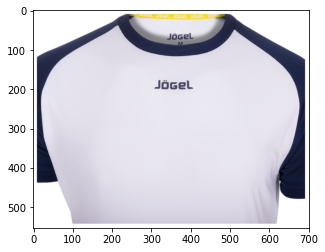

matches with


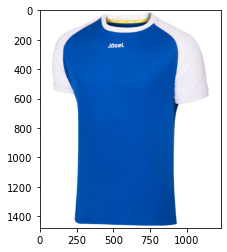

**********


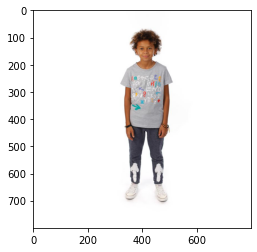

matches with


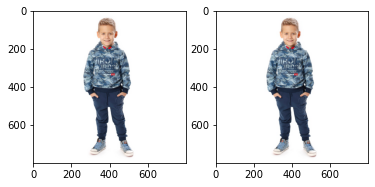

**********


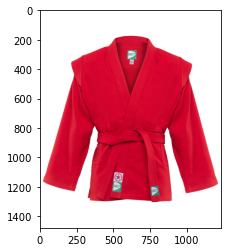

matches with


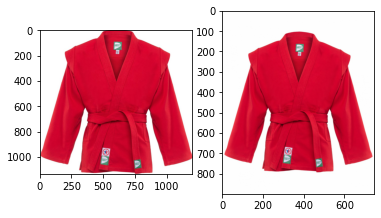

**********


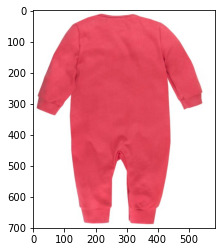

matches with


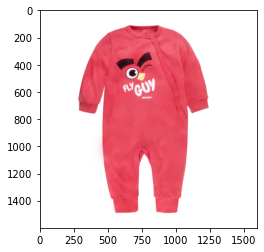

**********


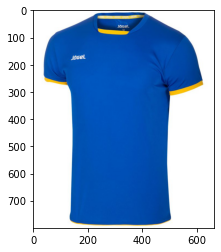

matches with


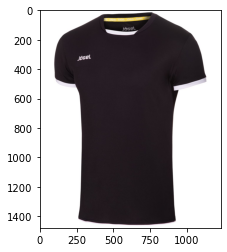

**********


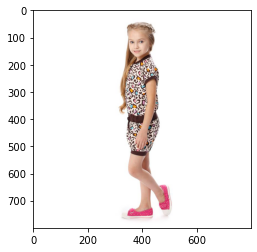

matches with


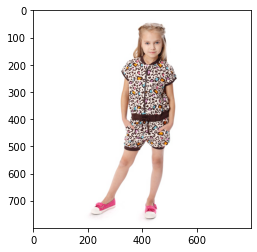

**********


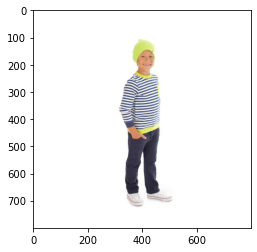

matches with


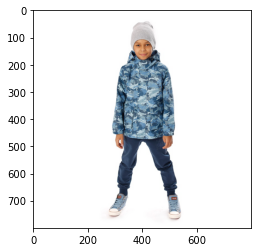

**********


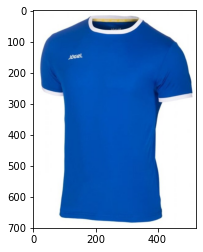

matches with


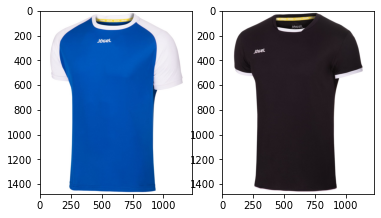

**********


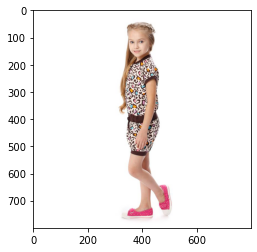

matches with


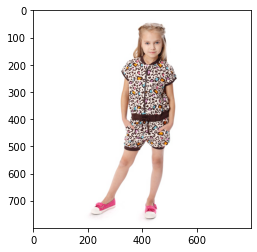

**********


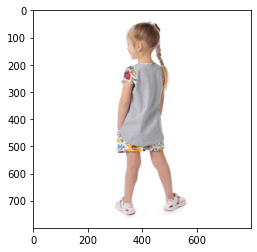

matches with


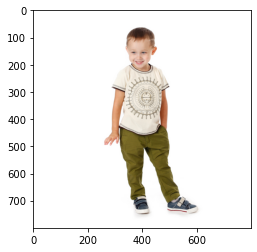

**********


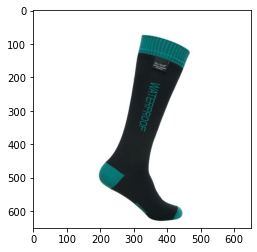

matches with


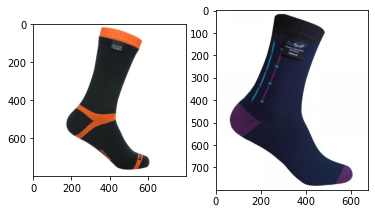

**********


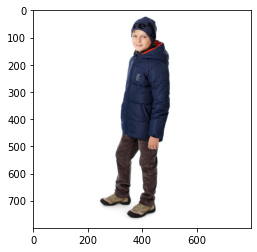

matches with


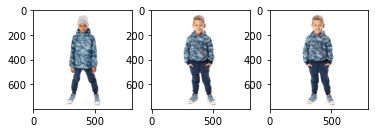

**********


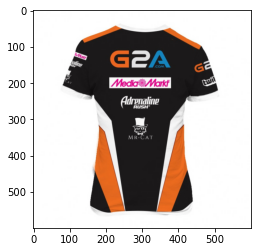

matches with


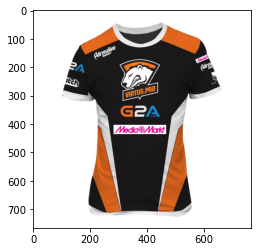

**********


In [13]:
#В качестве запросов будут файлы из папки B, в качестве ответов (пар) - файлы из папки А.
def infer(model, path, tr):
    all_queries = listdir(path)
    for img in all_queries:
        model.predict(path+img, tr)
#Задние пути к запросов и границы для tr. Если сходство между векторами меньше чем tr, то считается
#что фотографии не похожи.

path = 'data/B/'
tr = 0.85
infer(matcher_model, path, tr)